##Import Library & Load Data

In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Membaca data dari file excel
df = pd.read_excel('/content/data.xlsx', sheet_name='twitter')
normalization_dict = pd.read_excel('/content/data.xlsx', sheet_name='normalisasi')
normalization_dict = normalization_dict.fillna('').set_index('abnormal')['normal'].astype(str).to_dict()

## Data Preprocessing

In [3]:
# Fungsi untuk menghapus tag
def remove_tags(text):
    return re.sub(r'@\w+(\.\w+)*', '', text)

# Fungsi untuk menghapus link
def remove_links(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# Fungsi untuk menghapus semua karakter kecuali huruf dan spasi
def remove_non_alphabetic(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Fungsi untuk case folding
def case_folding(text):
    return text.lower()

# Fungsi untuk normalisasi kata
def normalize_text(text, normalization_dict):
    words = text.lower().split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Fungsi untuk menghapus stopword
stopwords = set(open('/content/stopwords.txt', 'r').read().split())

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]
    return ' '.join(words)

In [4]:
# Preprocessing data Twitter
df['text'] = df['text'].astype(str)
df['clean_text'] = df['text'].apply(remove_tags)
df['clean_text'] = df['clean_text'].apply(remove_links)
df['clean_text'] = df['clean_text'].apply(remove_non_alphabetic)
df['clean_text'] = df['clean_text'].apply(case_folding)
df['clean_text'] = df['clean_text'].apply(lambda x: normalize_text(x, normalization_dict))
df['clean_text'] = df['clean_text'].apply(remove_stopwords)

## Data Split, TF-IDF, and Data Augmentation

In [5]:
# Split data
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['sentiment'], random_state=42)

print("Distribusi data sebelum SMOTE:")
print(df_train['sentiment'].value_counts())

# TF-IDF Vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
X_test_tfidf = tfidf.transform(df_test['clean_text'])

y_train = df_train['sentiment']
y_test = df_test['sentiment']

Distribusi data sebelum SMOTE:
sentiment
negatif    95
netral     55
positif     8
Name: count, dtype: int64


In [6]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("\nDistribusi data setelah SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Distribusi data setelah SMOTE:
sentiment
negatif    95
netral     95
positif    95
Name: count, dtype: int64


##SVM Implementation

In [7]:
# Define custom scorer for F1 score of the negative class
scorer = make_scorer(f1_score, average='macro')

# Hyperparameter tuning for SVM
param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

svm = SVC()
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring=scorer, return_train_score=True)
grid_search_svm.fit(X_train_tfidf_smote, y_train_smote)

best_params_svm = grid_search_svm.best_params_
print(f"Parameter terbaik untuk SVM: {best_params_svm}")

Parameter terbaik untuk SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [8]:
# Display F1 score for each combination of hyperparameters
results_svm = pd.DataFrame(grid_search_svm.cv_results_)
print("\nHasil F1-score untuk setiap kombinasi hyperparameter SVM:")
print(results_svm[['params', 'mean_test_score', 'rank_test_score']])


Hasil F1-score untuk setiap kombinasi hyperparameter SVM:
                                               params  mean_test_score  \
0    {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}         0.872686   
1      {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}         0.778270   
2       {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}         0.860346   
3   {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}         0.880523   
4     {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}         0.872686   
5       {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}         0.725804   
6        {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}         0.846166   
7    {'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}         0.846166   
8      {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}         0.929037   
9        {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}         0.855057   
10        {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.918358   
11    {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}

In [9]:
svm = SVC(C=1, kernel='linear')
svm.fit(X_train_tfidf_smote, y_train_smote)
y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm))

SVM Evaluation:
              precision    recall  f1-score   support

     negatif       0.91      0.93      0.92        42
      netral       0.83      0.83      0.83        24
     positif       0.50      0.33      0.40         3

    accuracy                           0.87        69
   macro avg       0.75      0.70      0.72        69
weighted avg       0.86      0.87      0.87        69



Confusion Matrix:
 [[39  3  0]
 [ 3 20  1]
 [ 1  1  1]]


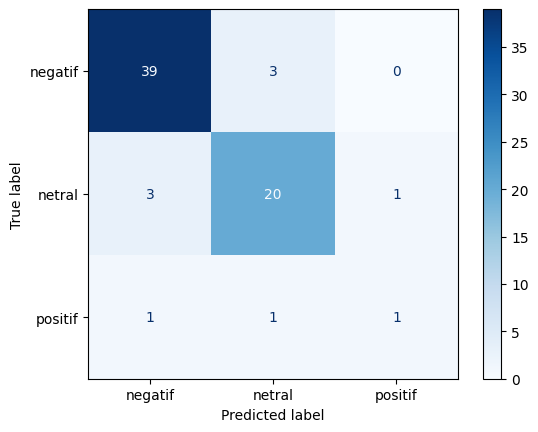

In [10]:
cm = confusion_matrix(y_test, y_pred_svm, labels=["negatif", "netral", "positif"])
print("Confusion Matrix:\n", cm)

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negatif", "netral", "positif"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

##KNN Implementation

In [11]:
# Hyperparameter tuning for KNN
param_grid_knn = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring=scorer, return_train_score=True)
grid_search_knn.fit(X_train_tfidf_smote, y_train_smote)

best_params_knn = grid_search_knn.best_params_
print(f"Parameter terbaik untuk KNN: {best_params_knn}")

Parameter terbaik untuk KNN: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}


In [12]:
# Display F1 score for each combination of hyperparameters
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
print("\nHasil F1-score untuk setiap kombinasi hyperparameter KNN:")
print(results_knn[['params', 'mean_test_score', 'rank_test_score']])


Hasil F1-score untuk setiap kombinasi hyperparameter KNN:
                                                params  mean_test_score  \
0    {'metric': 'euclidean', 'n_neighbors': 1, 'wei...         0.800106   
1    {'metric': 'euclidean', 'n_neighbors': 1, 'wei...         0.800106   
2    {'metric': 'euclidean', 'n_neighbors': 2, 'wei...         0.858021   
3    {'metric': 'euclidean', 'n_neighbors': 2, 'wei...         0.860342   
4    {'metric': 'euclidean', 'n_neighbors': 3, 'wei...         0.781021   
..                                                 ...              ...   
175  {'metric': 'minkowski', 'n_neighbors': 28, 'we...         0.674150   
176  {'metric': 'minkowski', 'n_neighbors': 29, 'we...         0.585359   
177  {'metric': 'minkowski', 'n_neighbors': 29, 'we...         0.677269   
178  {'metric': 'minkowski', 'n_neighbors': 30, 'we...         0.576310   
179  {'metric': 'minkowski', 'n_neighbors': 30, 'we...         0.673927   

     rank_test_score  
0                

In [13]:
knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 2, weights= 'distance')
knn.fit(X_train_tfidf_smote, y_train_smote)
y_pred_knn = knn.predict(X_test_tfidf)

print("KNN Evaluation:")
print(classification_report(y_test, y_pred_knn))

KNN Evaluation:
              precision    recall  f1-score   support

     negatif       0.74      0.88      0.80        42
      netral       0.69      0.46      0.55        24
     positif       0.33      0.33      0.33         3

    accuracy                           0.71        69
   macro avg       0.59      0.56      0.56        69
weighted avg       0.70      0.71      0.70        69



Confusion Matrix:
 [[37  4  1]
 [12 11  1]
 [ 1  1  1]]


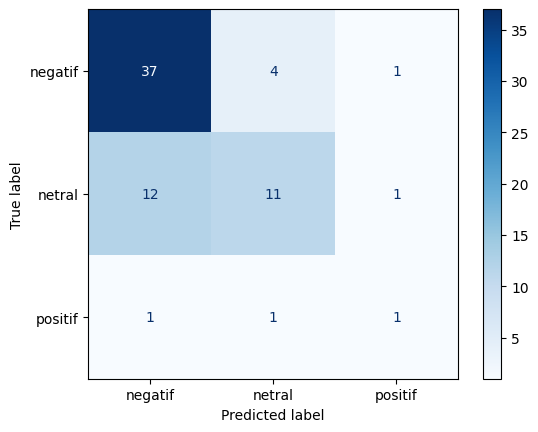

In [14]:
cm = confusion_matrix(y_test, y_pred_knn, labels=["negatif", "netral", "positif"])
print("Confusion Matrix:\n", cm)

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negatif", "netral", "positif"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

##Instagram Data Prediction

In [15]:
# Membaca data Instagram
df_instagram = pd.read_excel('/content/data.xlsx', sheet_name='instagram')

# Preprocessing data Instagram
df_instagram['text'] = df_instagram['text'].astype(str)
df_instagram['clean_text'] = df_instagram['text'].apply(remove_tags)
df_instagram['clean_text'] = df_instagram['clean_text'].apply(remove_links)
df_instagram['clean_text'] = df_instagram['clean_text'].apply(remove_non_alphabetic)
df_instagram['clean_text'] = df_instagram['clean_text'].apply(case_folding)
df_instagram['clean_text'] = df_instagram['clean_text'].apply(lambda x: normalize_text(x, normalization_dict))
df_instagram['clean_text'] = df_instagram['clean_text'].apply(remove_stopwords)

In [16]:
X_instagram_tfidf = tfidf.transform(df_instagram['clean_text'])

# Memprediksi data Instagram
df_instagram['predicted_sentiment'] = svm.predict(X_instagram_tfidf)

In [18]:
# Evaluasi model pada data Instagram
print("Instagram Evaluation:")
print(classification_report(df_instagram['sentiment'], df_instagram['predicted_sentiment']))

Instagram Evaluation:
              precision    recall  f1-score   support

     negatif       0.68      0.67      0.68       120
      netral       0.81      0.88      0.85       260
     positif       0.80      0.47      0.59        43

    accuracy                           0.78       423
   macro avg       0.77      0.67      0.70       423
weighted avg       0.78      0.78      0.77       423



Confusion Matrix Instagram:
 [[ 80  39   1]
 [ 27 229   4]
 [ 10  13  20]]


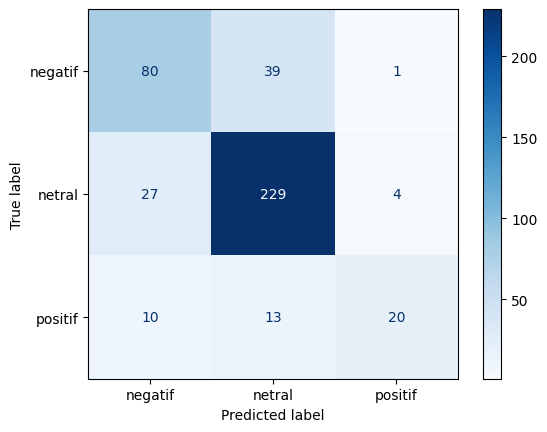

In [17]:
cm_instagram = confusion_matrix(df_instagram['sentiment'], df_instagram['predicted_sentiment'], labels=["negatif", "netral", "positif"])
print("Confusion Matrix Instagram:\n", cm_instagram)

# Visualisasi confusion matrix untuk data Instagram
disp_instagram = ConfusionMatrixDisplay(confusion_matrix=cm_instagram, display_labels=["negatif", "netral", "positif"])
disp_instagram.plot(cmap=plt.cm.Blues)
plt.show()

##Wordcloud

In [44]:
def generate_wordcloud(text, title, min_freq=1):
    # Menghitung frekuensi kata
    word_counts = Counter(' '.join(text).split())
    # Menyaring kata-kata berdasarkan frekuensi minimum
    filtered_words = {word: freq for word, freq in word_counts.items() if freq >= min_freq}

    # Membuat word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

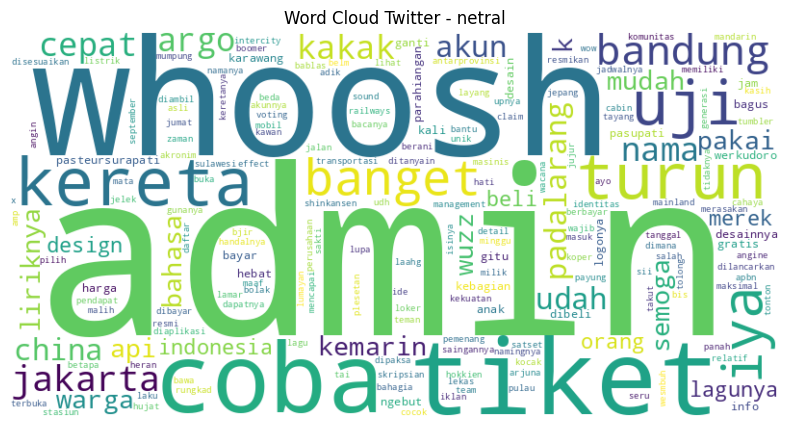

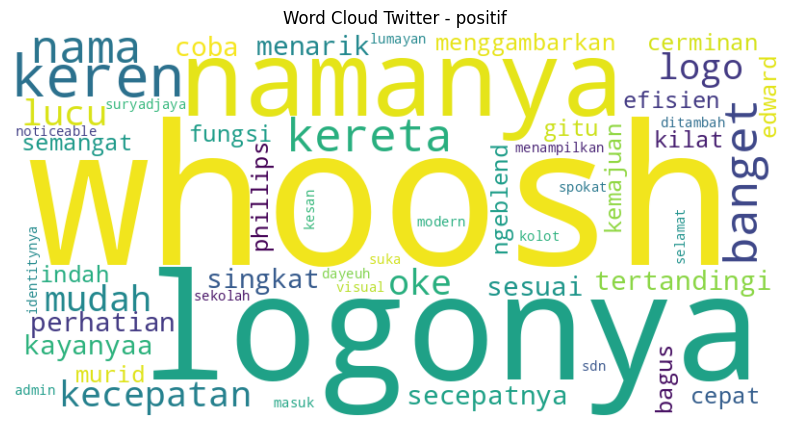

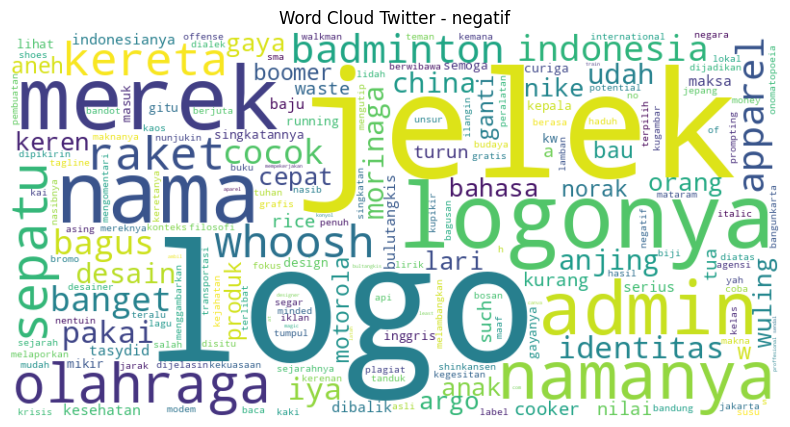

In [45]:
# Membuat word cloud untuk masing-masing sentimen pada data Twitter
for sentiment in df['sentiment'].unique():
    sentiment_text = df[df['sentiment'] == sentiment]['clean_text']
    generate_wordcloud(sentiment_text, f"Word Cloud Twitter - {sentiment}")

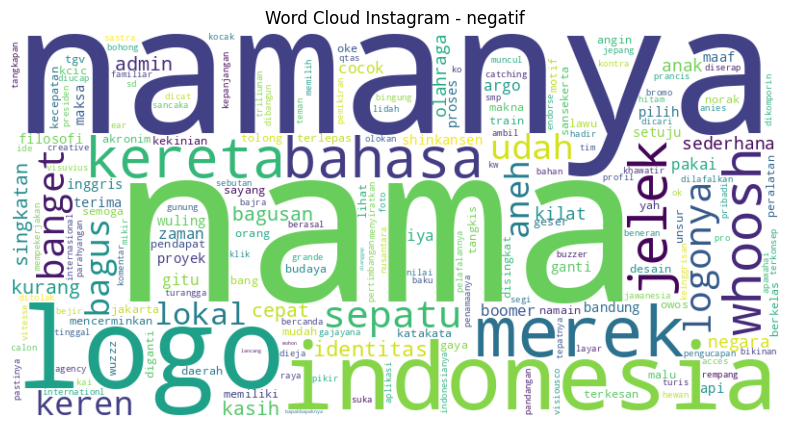

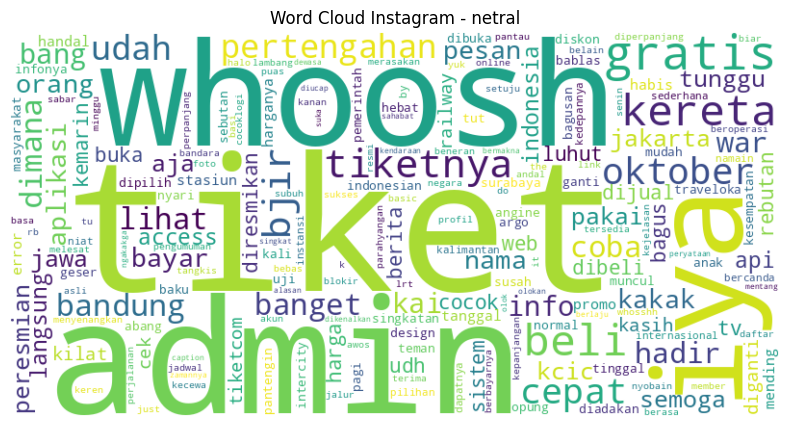

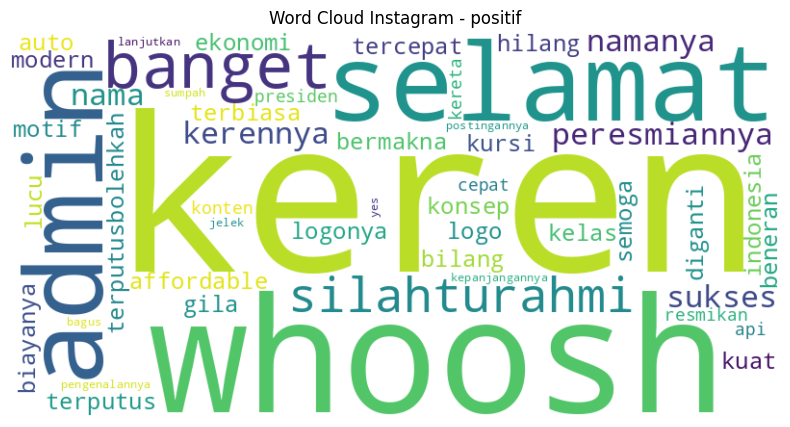

In [46]:
# Membuat word cloud untuk masing-masing sentimen pada data Instagram berdasarkan prediksi
for sentiment in df_instagram['predicted_sentiment'].unique():
    sentiment_text = df_instagram[df_instagram['predicted_sentiment'] == sentiment]['clean_text']
    generate_wordcloud(sentiment_text, f"Word Cloud Instagram - {sentiment}")